In [83]:
import random
import ntpath
import os 
import cv2
import pandas as pd 
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

In [14]:
cols =['center','left','right','steering','throttle','reverse','speed']

In [15]:
df = pd.read_csv('driving_log.csv',names=cols)

In [16]:
df.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Hamza\Documents\IMG\center_2024_08_23...,C:\Users\Hamza\Documents\IMG\left_2024_08_23_1...,C:\Users\Hamza\Documents\IMG\right_2024_08_23_...,0.0,0.000000,0,6.720634
1,C:\Users\Hamza\Documents\IMG\center_2024_08_23...,C:\Users\Hamza\Documents\IMG\left_2024_08_23_1...,C:\Users\Hamza\Documents\IMG\right_2024_08_23_...,0.0,0.214019,0,6.775555
2,C:\Users\Hamza\Documents\IMG\center_2024_08_23...,C:\Users\Hamza\Documents\IMG\left_2024_08_23_1...,C:\Users\Hamza\Documents\IMG\right_2024_08_23_...,0.0,0.423140,0,7.042279
3,C:\Users\Hamza\Documents\IMG\center_2024_08_23...,C:\Users\Hamza\Documents\IMG\left_2024_08_23_1...,C:\Users\Hamza\Documents\IMG\right_2024_08_23_...,0.0,0.635189,0,7.396773
4,C:\Users\Hamza\Documents\IMG\center_2024_08_23...,C:\Users\Hamza\Documents\IMG\left_2024_08_23_1...,C:\Users\Hamza\Documents\IMG\right_2024_08_23_...,0.0,0.888528,0,8.282928


In [17]:
def get_tail(path):
  _, tail = ntpath.split(path)
  return tail

In [18]:
df['center'] = df['center'].apply(get_tail)
df['left'] = df['left'].apply(get_tail)
df['right'] = df['right'].apply(get_tail)
df.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2024_08_23_16_49_38_474.jpg,left_2024_08_23_16_49_38_474.jpg,right_2024_08_23_16_49_38_474.jpg,0.0,0.000000,0,6.720634
1,center_2024_08_23_16_49_38_543.jpg,left_2024_08_23_16_49_38_543.jpg,right_2024_08_23_16_49_38_543.jpg,0.0,0.214019,0,6.775555
2,center_2024_08_23_16_49_38_613.jpg,left_2024_08_23_16_49_38_613.jpg,right_2024_08_23_16_49_38_613.jpg,0.0,0.423140,0,7.042279
3,center_2024_08_23_16_49_38_683.jpg,left_2024_08_23_16_49_38_683.jpg,right_2024_08_23_16_49_38_683.jpg,0.0,0.635189,0,7.396773
4,center_2024_08_23_16_49_38_770.jpg,left_2024_08_23_16_49_38_770.jpg,right_2024_08_23_16_49_38_770.jpg,0.0,0.888528,0,8.282928


In [20]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['steering'], num_bins)

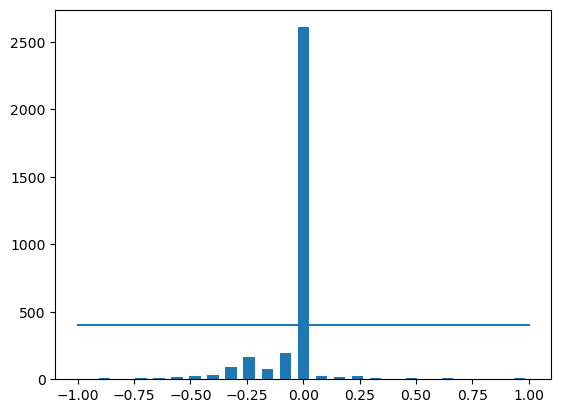

In [31]:
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(df['steering']), np.max(df['steering'])), \
(samples_per_bin, samples_per_bin))

In [36]:
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(df['steering'])):
    if df['steering'][i] >= bins[j] and df['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed:', len(remove_list))

removed: 2207


In [40]:
df.drop(df.index[remove_list], inplace=True)
print('remaining:', len(df))

remaining: 1146


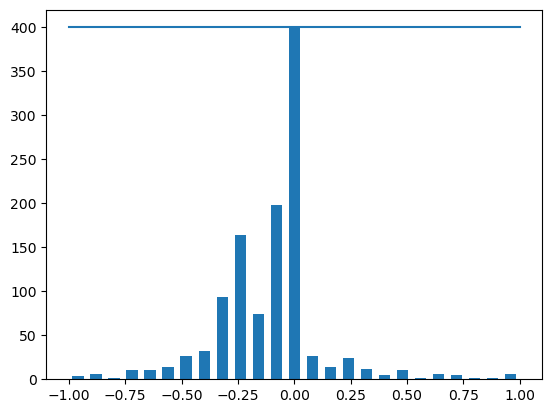

In [43]:
hist, _ = np.histogram(df['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(df['steering']), np.max(df['steering'])), \
(samples_per_bin, samples_per_bin))

In [46]:
datadir = ''
def load_img_steering(datadir, df):
    image_paths = []
    steerings = []
    for index, row in df.iterrows():
        center, left, right, steering_angle = row[:4]
        image_paths.extend([
            os.path.join(datadir, center.strip()),
            os.path.join(datadir, left.strip()),
            os.path.join(datadir, right.strip())
        ])
        steerings.extend([
            float(steering_angle),
            float(steering_angle) + 0.15,
            float(steering_angle) - 0.15
        ])
    return np.array(image_paths), np.array(steerings)
image_paths, steerings = load_img_steering(datadir + 'IMG', df)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(image_paths, steerings, test_size=0.2, random_state=404)

Text(0.5, 1.0, 'Validation set')

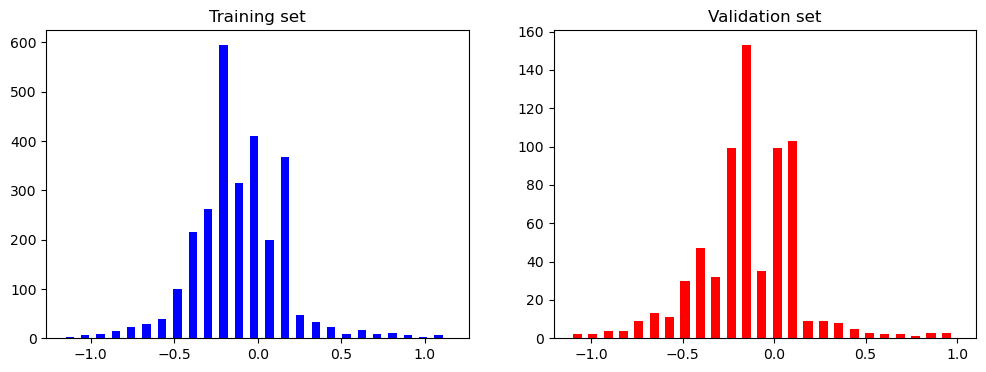

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_test, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [57]:
def zoom(image):
    return iaa.Affine(scale=(1, 1.3)).augment_image(image)

def pan(image):
    return iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}).augment_image(image)

def img_random_brightness(image):
    return iaa.Multiply((0.2, 1.2)).augment_image(image)

def img_random_flip(image, steering_angle):
    return cv2.flip(image, 1), -steering_angle

In [79]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if random.random() < 0.5: image = pan(image)
    if random.random() < 0.5: image = zoom(image)
    if random.random() < 0.5: image = img_random_brightness(image)
    if random.random() < 0.5: image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle

In [59]:
def img_preprocess(img):
    img = cv2.cvtColor(img[60:135, :, :], cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    return cv2.resize(img, (200, 66)) / 255.0

In [81]:
def batch_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images, batch_steering = [], []
        for _ in range(batch_size):
            index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[index]
            steering_angle = steering_angles[index]
            
            if is_training:
                img = mpimg.imread(image_path)
                img, steering_angle = random_augment(image_path, steering_angle)
            else:
                img = mpimg.imread(image_path)
            
            img = img_preprocess(img)
            batch_images.append(img)
            batch_steering.append(steering_angle)
        
        yield np.array(batch_images), np.array(batch_steering)

In [74]:
def nvidiaModel():
  model = Sequential()
  model.add(Convolution2D(24,(5,5),strides=(2,2),input_shape=(66,200,3),activation="elu"))
  model.add(Convolution2D(36,(5,5),strides=(2,2),activation="elu"))
  model.add(Convolution2D(48,(5,5),strides=(2,2),activation="elu")) 
  model.add(Convolution2D(64,(3,3),activation="elu"))   
  model.add(Convolution2D(64,(3,3),activation="elu"))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(50,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(10,activation="elu"))
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.compile(optimizer=Adam(learning_rate=1e-3),loss="mse")
  return model

In [75]:
model = nvidiaModel()
print(model.summary())

C:\Users\Hamza\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 31, 98, 24)          │           1,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 47, 36)          │          21,636 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 5, 22, 48)           │          43,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 3, 20, 64)           │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 1, 18, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 18, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 100)                 │         115,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

None


In [84]:
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 145s 466ms/step - loss: 0.1547 - val_loss: 0.0589
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 135s 450ms/step - loss: 0.0660 - val_loss: 0.0546
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 139s 465ms/step - loss: 0.0626 - val_loss: 0.0529
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 135s 451ms/step - loss: 0.0605 - val_loss: 0.0563
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 138s 461ms/step - loss: 0.0591 - val_loss: 0.0475
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 132s 440ms/step - loss: 0.0614 - val_loss: 0.0491
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 132s 442ms/step - loss: 0.0580 - val_loss: 0.0458
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 132s 440ms/step - loss: 0.0571 - val_loss: 0.0440
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 132s 440ms/step - loss: 0.0564 - val_loss: 0.0450
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 133s 444ms/step - loss: 0.0551 - val_loss: 0.0453


In [85]:
model.save('my_model.h5')

In [86]:
model.save('my_model.keras')